# Statistics

Generate statistics from the `csv` files.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime
from math import sqrt

In [3]:
openssl_dataframe = pandas.read_csv('../openssl_files/results_distinct.csv')
ssh_dataframe = pandas.read_csv('../result_files/results_ssh.csv')
tcp_dataframe = pandas.read_csv('../result_files/results_tcp.csv')

big_dataframe = pandas.concat([openssl_dataframe, ssh_dataframe, tcp_dataframe], join='inner')

## RQ1: Do SMT solvers scale in the state-based comparison of real-world models?


,reference version,updated version,total hours,SMT solver
19,TCP_FreeBSD_Server,TCP_Linux_Server,12.440584,msat
20,TCP_FreeBSD_Server,TCP_Linux_Server,9.002594,msat
21,TCP_FreeBSD_Server,TCP_Linux_Server,19.765870,msat
12,TCP_FreeBSD_Server,TCP_FreeBSD_Server,6.587390,z3
14,TCP_FreeBSD_Server,TCP_FreeBSD_Server,14.005340,z3
26,TCP_FreeBSD_Server,TCP_Linux_Server,6.843588,z3
28,TCP_FreeBSD_Server,TCP_Linux_Server,14.536082,z3
59,TCP_Linux_Server,TCP_FreeBSD_Server,10.785647,z3
60,TCP_Linux_Server,TCP_FreeBSD_Server,15.349598,z3


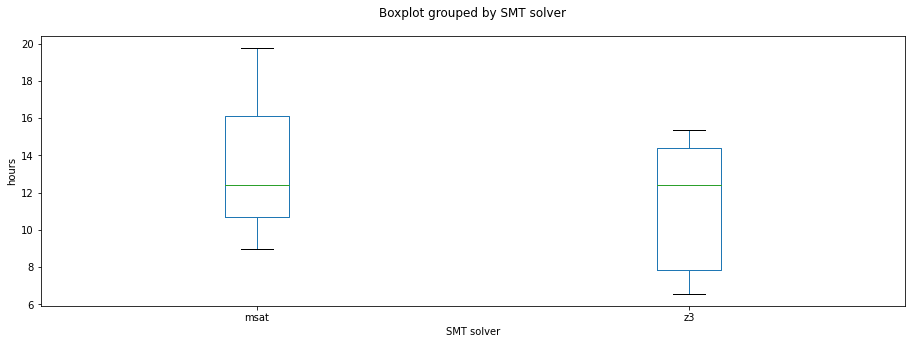

In [4]:
finish_time = datetime.timedelta(hours=6)

unfinshed = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) >= finish_time.total_seconds()]
unfinshed.insert(2, "total hours", [ (i+j)/3600 for i,j in zip(unfinshed['incoming time'], unfinshed['outgoing time'])])
unfinshed = unfinshed[['reference version', 'updated version', 'total hours', 'SMT solver']]

display(unfinshed.sort_values('SMT solver'))
axs = unfinshed.boxplot(by='SMT solver', grid=False, figsize=(15,5))
axs.set_ylabel("hours")
axs.set_xlabel("SMT solver")
axs.set_title("")
None

## RQ2: Is one SMT solver superior to the other solvers?

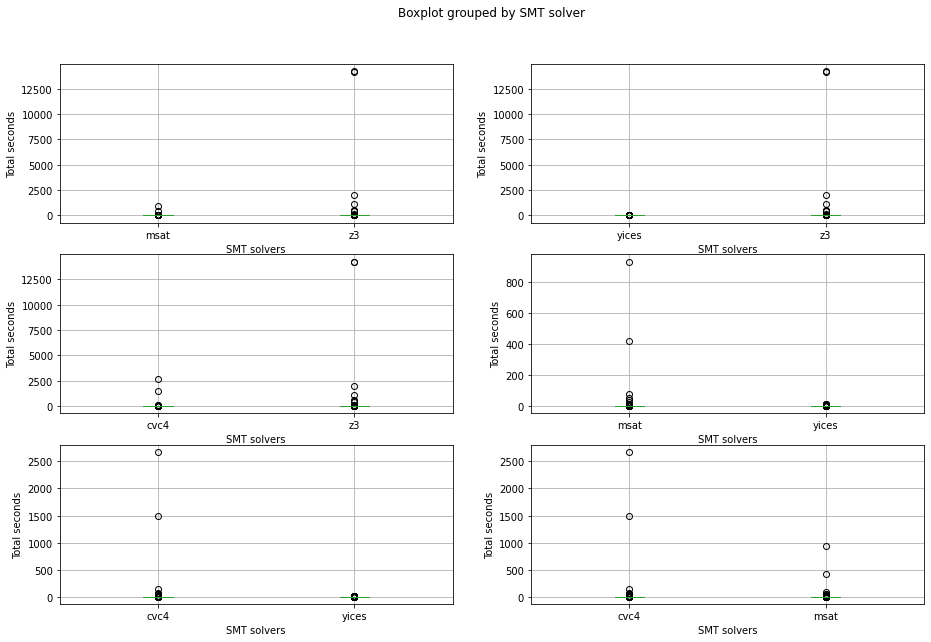

In [5]:
finshed_settings_frame = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) < finish_time.total_seconds()]
finshed_settings_frame.insert(3,"total seconds", [ (i+j) for i,j in zip(finshed_settings_frame['incoming time'], finshed_settings_frame['outgoing time'])])

average = finshed_settings_frame.groupby(["reference version", "updated version", "SMT solver"]).mean().reset_index()
sample_set = average[["reference version", "updated version", "SMT solver","total seconds"]]

sample_set.insert(2, "count", sample_set.groupby(["reference version", "updated version"])["SMT solver"].transform("count"))

only_finished = sample_set[sample_set["count"] == 4][["reference version", "updated version", "SMT solver","total seconds"]]

fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 10)

def show_finished_box_plot(solver1, solver2, ax):
    only_finished[(only_finished["SMT solver"] == solver1) | (only_finished["SMT solver"] == solver2)].boxplot(by="SMT solver", figsize=(15,5), ax=ax)
    ax.set_xlabel("SMT solvers")
    ax.set_ylabel("Total seconds")
    ax.set_title("")
    

show_finished_box_plot("z3", "msat", axes[0,0])
show_finished_box_plot("z3", "yices", axes[0,1])
show_finished_box_plot("z3", "cvc4", axes[1,0])

show_finished_box_plot("yices", "msat", axes[1,1])
show_finished_box_plot("yices", "cvc4", axes[2,0])

show_finished_box_plot("msat", "cvc4", axes[2,1])


In [22]:
# Statistical analysis (T-test, Wilcoxon signed-rank test, Effect size)
# Wilcoxon signed-rank test, data does need to be linear. (my data isn't)
# Source: https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

z3_finished = only_finished[only_finished["SMT solver"] == "z3"]["total seconds"]
yices_finished = only_finished[only_finished["SMT solver"] == "yices"]["total seconds"]
msat_finished = only_finished[only_finished["SMT solver"] == "msat"]["total seconds"]
cvc4_finished = only_finished[only_finished["SMT solver"] == "cvc4"]["total seconds"]

#Effect size (https://machinelearningmastery.com/effect-size-measures-in-python/)
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s


def effect_size(d):
    if d < 0:
        d = -1 * d
    if d < 0.2:
        return "Ignored"
    elif d < 0.5:
        return "Small"
    elif d < 0.8:
        return "Moderate"
    elif d < 1.4:
        return "Large"
    return "Very Large"
effect_size_list = []
effect_size_list.append({"SMT1" : "z3", "SMT2" : "yices", "Effect size" : cohend(z3_finished,yices_finished)})
effect_size_list.append({"SMT1" : "z3", "SMT2" : "msat", "Effect size" : cohend(z3_finished,msat_finished)})
effect_size_list.append({"SMT1" : "z3", "SMT2" : "cvc4", "Effect size" : cohend(z3_finished,cvc4_finished)})
effect_size_list.append({"SMT1" : "yices", "SMT2" : "z3", "Effect size" : cohend(yices_finished,z3_finished)})
effect_size_list.append({"SMT1" : "yices", "SMT2" : "msat", "Effect size" : cohend(yices_finished,msat_finished)})
effect_size_list.append({"SMT1" : "yices", "SMT2" : "cvc4", "Effect size" : cohend(yices_finished,cvc4_finished)})
effect_size_list.append({"SMT1" : "msat", "SMT2" : "z3", "Effect size" : cohend(msat_finished,z3_finished)})
effect_size_list.append({"SMT1" : "msat", "SMT2" : "yices", "Effect size" : cohend(msat_finished,yices_finished)})
effect_size_list.append({"SMT1" : "msat", "SMT2" : "cvc4", "Effect size" : cohend(msat_finished,cvc4_finished)})
effect_size_list.append({"SMT1" : "cvc4", "SMT2" : "z3", "Effect size" : cohend(cvc4_finished,z3_finished)})
effect_size_list.append({"SMT1" : "cvc4", "SMT2" : "yices", "Effect size" : cohend(cvc4_finished,yices_finished)})
effect_size_list.append({"SMT1" : "cvc4", "SMT2" : "msat", "Effect size" : cohend(cvc4_finished,msat_finished)})


effect_size_frame = pandas.DataFrame(effect_size_list)
effect_size_frame.insert(2,"Relative size", [ effect_size(i) for i in effect_size_frame['Effect size'] ])
display(effect_size_frame)


,SMT1,SMT2,Relative size,Effect size
0,z3,yices,Ignored,0.139990
1,z3,msat,Ignored,0.133388
2,z3,cvc4,Ignored,0.119654
3,yices,z3,Ignored,-0.139990
4,yices,msat,Ignored,-0.126037
5,yices,cvc4,Ignored,-0.125017
6,msat,z3,Ignored,-0.133388
7,msat,yices,Ignored,0.126037
8,msat,cvc4,Ignored,-0.078338
9,cvc4,z3,Ignored,-0.119654


## RQ3: Does the runtime of the solvers correlate to the size of the model changes?

### RQ3.1: Exection time vs number of state pairs

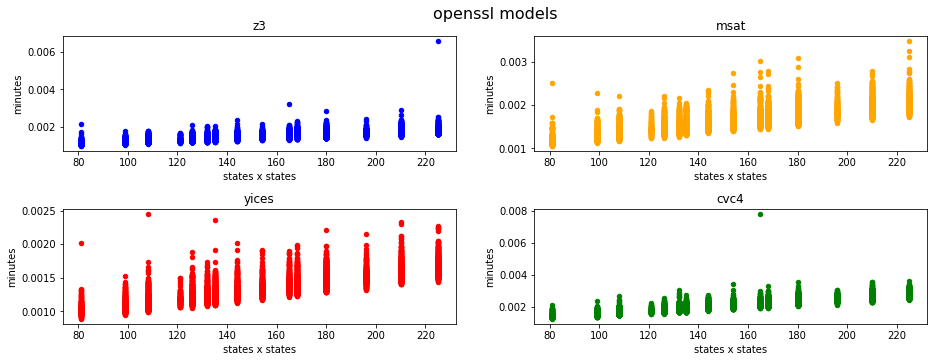

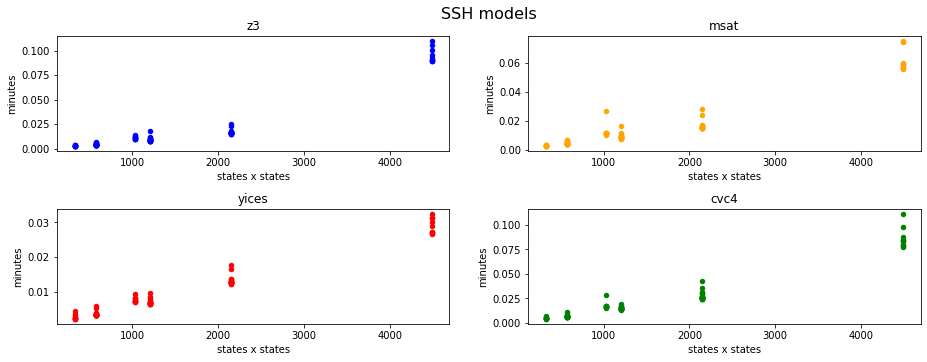

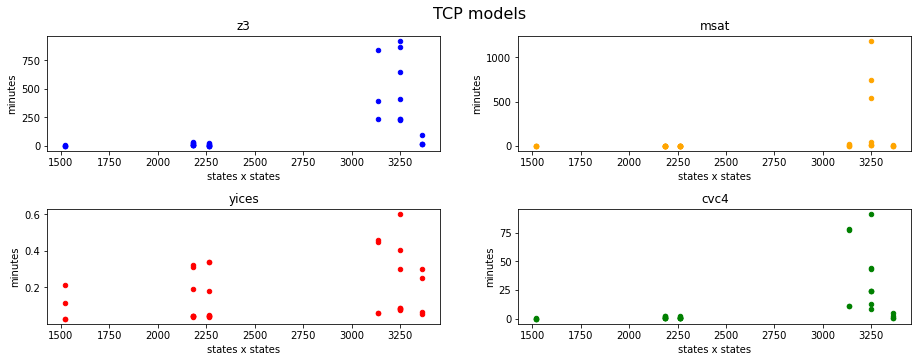

In [41]:
def exection_time_vs_state_pairs(dataframe, title):
    result_frame = dataframe[['SMT solver']]
    result_frame.insert(1,"states x states",[i*j for i,j in zip(dataframe['reference model: number of states'], dataframe['updated model: number of states'])])
    result_frame.insert(1,"minutes",[(i+j)/60 for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])


    fig, axes = plt.subplots(nrows=2,ncols=2)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(15, 5)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.5)

    result_frame[result_frame['SMT solver'] == 'z3'].plot.scatter("states x states", "minutes", c="blue", subplots=True ,ax=axes[0,0])
    axes[0,0].set_title("z3")

    result_frame[result_frame['SMT solver'] == 'msat'].plot.scatter("states x states", "minutes", c="orange", subplots=True ,ax=axes[0,1])
    axes[0,1].set_title("msat")

    result_frame[result_frame['SMT solver'] == 'yices'].plot.scatter("states x states", "minutes", c="red", subplots=True ,ax=axes[1,0])
    axes[1,0].set_title("yices")

    result_frame[result_frame['SMT solver'] == 'cvc4'].plot.scatter("states x states", "minutes", c="green", subplots=True ,ax=axes[1,1])
    axes[1,1].set_title("cvc4")
    

    
exection_time_vs_state_pairs(openssl_dataframe, "openssl models")
exection_time_vs_state_pairs(ssh_dataframe, "SSH models")   
exection_time_vs_state_pairs(tcp_dataframe, "TCP models")   



### RQ3.2: Execution time vs performance metrics

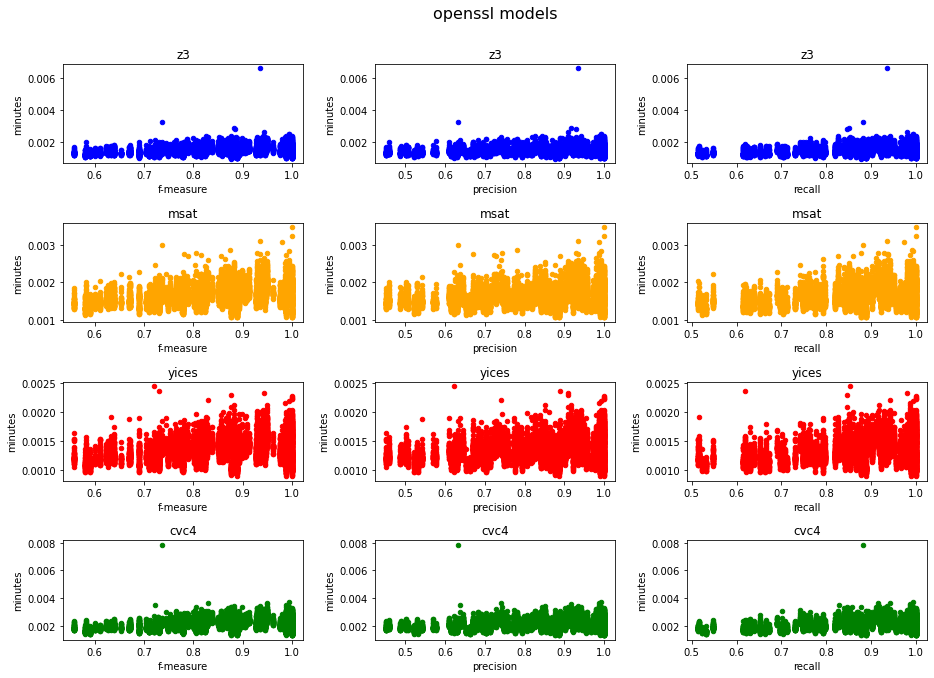

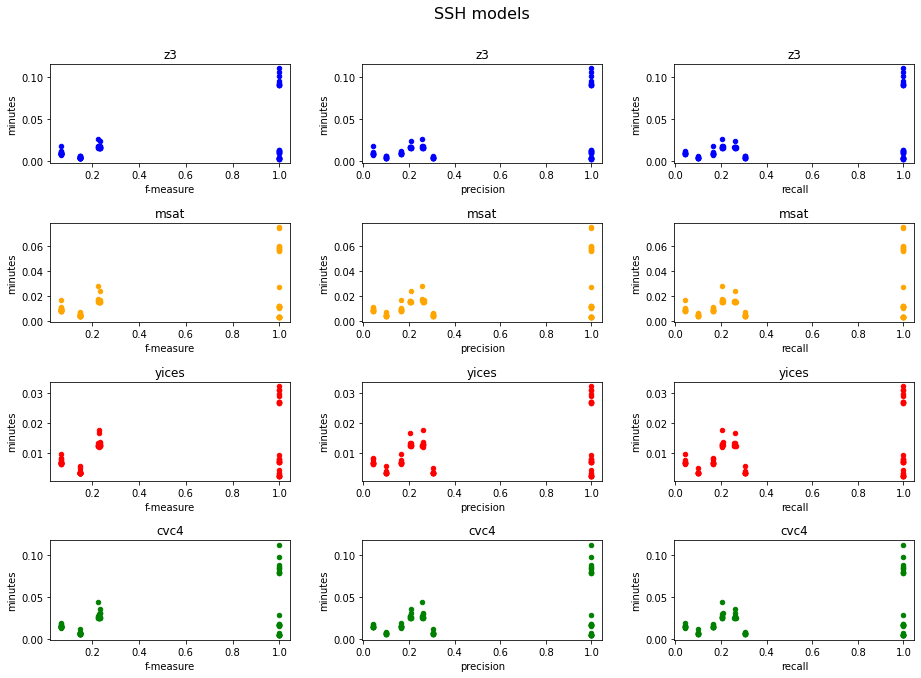

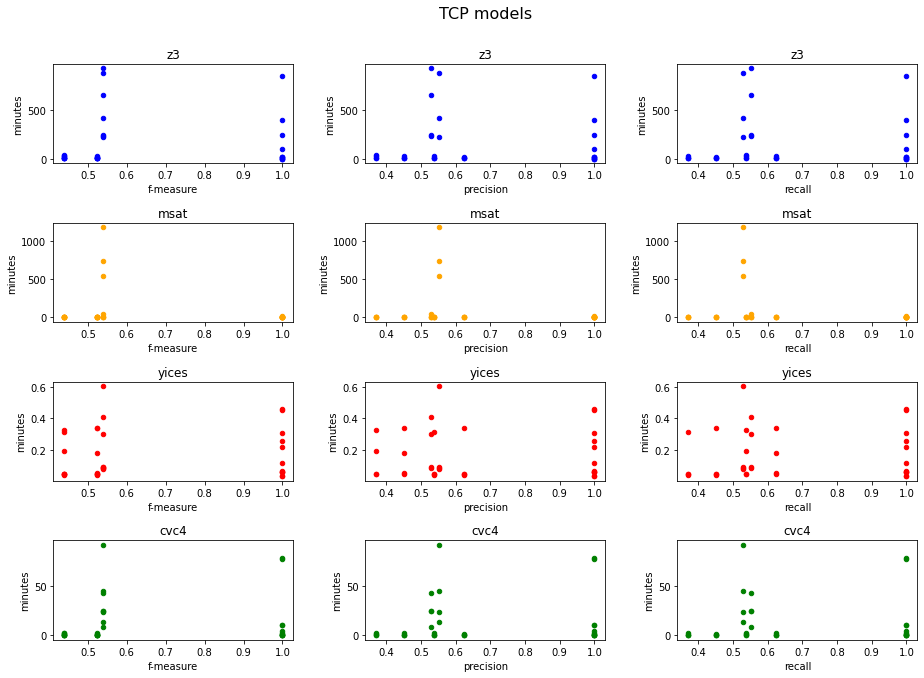

In [34]:


def draw_performance_time_plot(solver, color, row, dataframe, axes):
    dataframe[dataframe['SMT solver'] == solver].plot.scatter("f-measure", "minutes", c=color, subplots=True ,ax=axes[row,0])
    axes[row,0].set_title(solver)
    dataframe[dataframe['SMT solver'] == solver].plot.scatter("precision", "minutes", c=color, subplots=True ,ax=axes[row,1])
    axes[row,1].set_title(solver)
    dataframe[dataframe['SMT solver'] == solver].plot.scatter("recall", "minutes", c=color, subplots=True ,ax=axes[row,2])
    axes[row,2].set_title(solver)

def execution_time_vs_performance(dataframe, title):
    performance_frame = dataframe[['SMT solver', 'f-measure', 'precision', 'recall']]
    performance_frame.insert(1,"minutes",[(i+j)/60 for i,j in zip(dataframe['incoming time'], dataframe['outgoing time'])])


    fig, axes = plt.subplots(nrows=4,ncols=3)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(15, 10)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.3, 
                        hspace=0.6)

    draw_performance_time_plot("z3", "blue", 0, performance_frame, axes)
    draw_performance_time_plot("msat", "orange", 1, performance_frame, axes)
    draw_performance_time_plot("yices", "red", 2, performance_frame, axes)
    draw_performance_time_plot("cvc4", "green", 3, performance_frame, axes)

execution_time_vs_performance(openssl_dataframe, "openssl models")
execution_time_vs_performance(ssh_dataframe, "SSH models")   
execution_time_vs_performance(tcp_dataframe, "TCP models")   



## RQ4: How does the difference between models change during the evolution of a system?

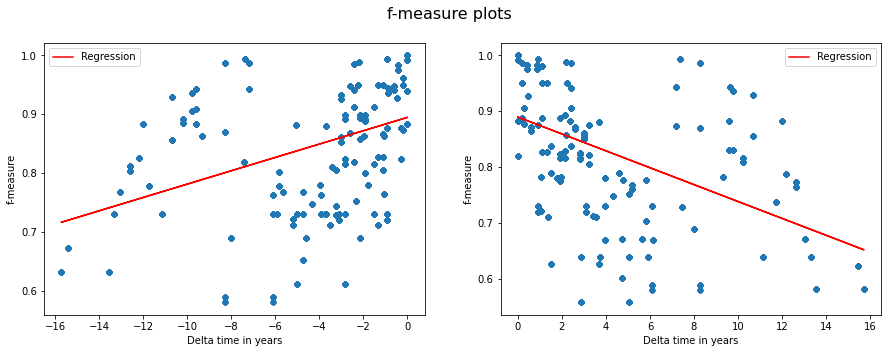

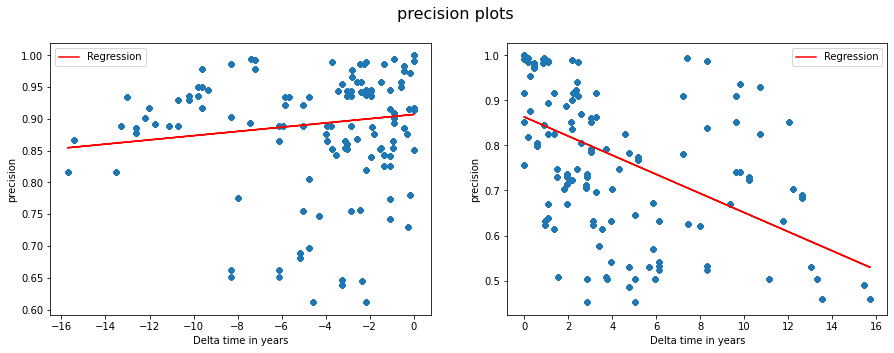

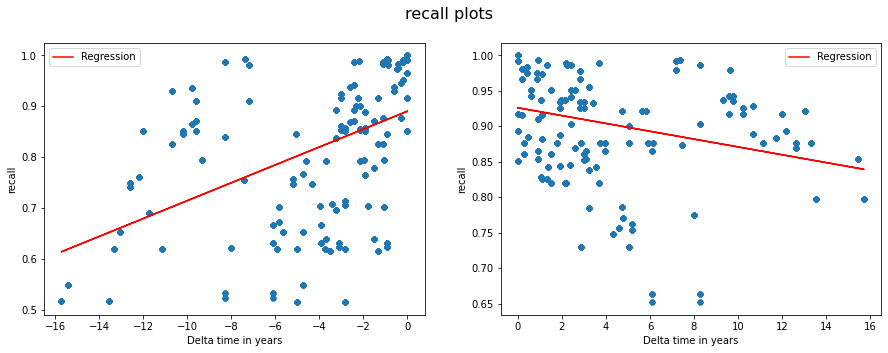

In [35]:
openssl_evolution = openssl_dataframe[openssl_dataframe['SMT solver'] == 'yices']
openssl_evolution.insert(0,'years', [ i/365 for i in openssl_evolution['delta date (days)']])
openssl_evolution = openssl_evolution[['years', 'f-measure', 'precision', 'recall']]


def plot_regression(y_value):
    
    negative = openssl_evolution[openssl_evolution['years'] <= 0]
    positive = openssl_evolution[openssl_evolution['years'] >= 0]

    d = np.polyfit(negative['years'],negative[y_value],1)
    f = np.poly1d(d)
    negative.insert(0,'Regression',f(negative['years']))

    d = np.polyfit(positive['years'],positive[y_value],1)
    f = np.poly1d(d)
    positive.insert(0,'Regression',f(positive['years']))

    fig, axes = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(y_value + " plots", fontsize=16)
    
    negative.plot.scatter('years', y_value, ax=axes[0], subplots=True)
    negative.plot(x='years', y='Regression',color='Red',ax=axes[0])
    axes[0].set_xlabel("Delta time in years")

    axs = positive.plot.scatter('years', y_value, ax=axes[1], subplots=True)
    positive.plot(x='years', y='Regression',color='Red',ax=axes[1])
    axes[1].set_xlabel("Delta time in years")

plot_regression('f-measure')
plot_regression('precision')
plot_regression('recall')